This repository is a tutorial dedicated to create a ML agent that can play chess in FHE using the Concrete-ML library. This work also [compete for a bounty program](https://github.com/zama-ai/bounty-program/blob/main/Bounties/Machine_Learning/create-an-app-play-chess-in-fhe.md).


The application of Fully Homomorphic Encryption (FHE) in deep learning lead us to rethink our process. Indeed, it allows us to encrypt the entire process while preserving the privacy of our data.

In this notebook, we will present a Deep Learning model for playing chess that leverages FHE. The FHE process involves several mandatory steps that significantly impact and change how we traditionally approach deep learning.


# A chess problem

When using FHE, a user will first encrypt a chess board locally. This encrypted data is then sent to a server, where an AI agent will receive the encrypted data and use it as input. It will then play his turn by trying to predict the best move, generating an encrypted output that only the user can decrypt. Finally, it sent it back to the client.


In this configuration, both the server and the agent receive an encrypted data. However, the server will not be able to understand the logic behind the encrypted data, whereas the agent can. Therefore, the IA agent uses as input this data and generates an encrypted move. This move will then be sent back to the user, who is the only one who can read and apply the agent's move.


Applying FHE, limite and constraint the proposed algorithm/model. As you may have already know, existing chess algorithm usually maximize gains by considering the next possible moves based on a given board. They generate all possible positions by iterating over valid moves, compute a score for each of them, and choose the one that optimizes the winning score. However, this logic cannot be implemented on the server side due to the encrypted nature of the board data. Consequently, this logic must be implemented on the client side.



## Our approach

Knowing those constraints, we decided to think about a simple approach that takes an encrypted board and generate as output a single move encrypted. In this approach, we do not want to generate all possible moves, but we want our model to predict the best move given a board. This allow us to limit the computation, as we need to evaluate only one board, and limit the algorithm logic on iterating over all possible moves.


### Board representation

In the chess game, we have two opponents the black and the white. The objective is to checkmate the opponent's king. The game is played on an 8 x 8 square board. Each team has multiples pieces: 1 king, 1 queen, 2 rooks 2 bishops, 2 knights and 8 pawns. The game starts with the white team making the first move, followed by the black team, and so on, until one king is checkmated. 

To develop a Deep Learning approach for this game, we first need to think about a way of representing a chessboard. Our input data will be a matrix of size 8 by 8.

There are different approaches to representing the pieces on the board. The first approach is to use one-hot encoding, where each piece has its own representation. In this case, we would have 12 encoding representations (12 different pieces). Therefore, our input shape would be 12x8x8.

However, this representation lacks explicit information about the current team turn. In the given board, we want to predict the next move for a specific team. By using one-hot encoding, we only specify to whom the piece belong to. Thus, we will need to introduce an additional parameter along with the board as input to our model to specify the current team's turn (white or black).

A second approach is to create a matrix where each channel represents a piece. In this representation, we will have 6 channels for the 6 pieces: king, queen, rook, bishop, knight and pawn. In those channels, the presence of a piece would be indicated by a 1 in its corresponding position, and depending on the current team playing, we can set the adversarial piece to -1. This representation reduces the input matrix and allows the representation of the opponent based on the current team. In the following notebook, we will use this representation.

This encoded board can then be use as input for our deep learning model. Now, let's consider the output representation of our model, which determines how our model will provide the next move.


### Predict the next move

To predict a next move, we need to consider two things: the piece that we intend to move and the position where we want to move that piece on the board. The position can be describe as two coordinates: one for the row and one for the columns.

In our implementation, we decided to see this problem as a classification one. Thus, at the end of our model, we will have three branches with: 

- Piece type prediction, determines the piece to be moved: 6 possibilities
- Row index prediction: 8 possibilities
- Column index prediction: 8 possibilities

This approach allow us to sumply send an encrypted board to the server and get back the best move predicted.

> **__Note:__** Regarding the piece prediction, an alternative approach could have been to consider the position of the piece that we intend to move instead of the piece type.

### Hypothesis

To simplify our implementation, we have made several hypothesis:

- Invalid moves: Our model can proposed an invalid moves, as the rules of chess are not hard-coded. To handle those cases, we can decide to use the output of our model as a density of probabilty, allowing us to generate a new move when an invalid one proposed by our model.

- Complex moves: In chess, special moves exist such as casting, promotion and en passant. In our current implementation, we will not focus our attention on those moves. It could be an improvement in the implementation of future models. As for the promotion, it will be always be a queen at the moment.

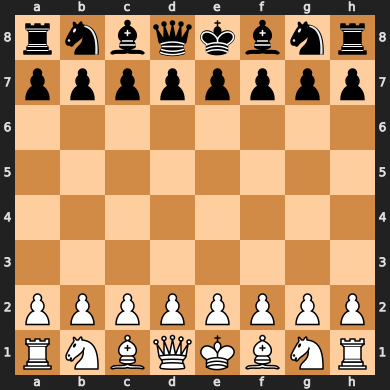

In [115]:
# Chess board example
import chess
chess.Board()


## Get the data

First of all, for all Deep Learning project, we need data. We will use the [lichess open library](https://database.lichess.org/#standard_games). We will have some data `.pgn.zst`. You can first decompress the data. (Note: the output file can be huge). Then, we need to export the data in an easy way to extract them. For that, we use the `PGNData` library. 

> Note: The library does not manage huge file, it is intereting to take a sample of it and then apply the export on it. Or to apply a fork that modify the behaviour of loading/writing the file. 

Code example: 

```python
from converter.pgn_data import PGNData

FILE_NAME = "lichess_db_standard_rated_2023-01.pgn"

pgn_data = PGNData(FILE_NAME)
pgn_data.export()
```
> Code extracted from the `parser.py`

After this treatment, we obtain at the end two files. One entitled `_moves.csv` and the other `_game_info.csv`. The `_game_info.csv` file gives us information about the metadata of the game. This is where we will access the metadata. Whereas, `_moves.csv` contains the moves sequence for the game.  

Regarding the extraction of the data, we decided to extract the game from `Rated Classical game` with an elo above 2000. We decided to not go with bullet game as the player need to play really quick moves and that can favorise missed moves.

We then extract the board, the next move and the piece use for this board. We gather this information in a single csv file. You can see our implementation in another notebook `./data/analyse.ipynb`


In [1]:
import os
import re
import time

import brevitas.nn as qnn
import chess
import numpy as np
import pandas as pd
import pytorch_lightning as pl
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, Dataset
from torchmetrics import Accuracy
from tqdm import tqdm_notebook as tqdm

In [2]:
# Hyperparameters

INPUT_DATA = "./data/large_samples_data.csv"

TRAINING = True

ACCELERATOR = "gpu"
NB_DEVICES  = 1


FHE_MODE = 0         # 0 -> simulate 
BIT_WIDTH = 4        # 
WEIGHT_BIT_WIDTH = 4 #

N_BITS_QAT = 4

In [4]:
df = pd.read_csv(INPUT_DATA)
df.head()

,Unnamed: 0.1,Unnamed: 0,game_id,event,white_elo,black_elo,to_square,piece,move_sequence,target_column,target_row,before_board,after_board,white_turn
0,0,0,8c9904ae-2c65-4b08-98df-bafa611489b4,Rated Classical game,2003,2041,e4,P,e4,e,4,r n b q k b n r\np p p p p p p p\n. . . . . . ...,r n b q k b n r\np p p p p p p p\n. . . . . . ...,True
1,1,1,8c9904ae-2c65-4b08-98df-bafa611489b4,Rated Classical game,2003,2041,e5,P,e4|e5,e,5,r n b q k b n r\np p p p p p p p\n. . . . . . ...,r n b q k b n r\np p p p . p p p\n. . . . . . ...,False
2,2,2,8c9904ae-2c65-4b08-98df-bafa611489b4,Rated Classical game,2003,2041,d4,P,e4|e5|d4,d,4,r n b q k b n r\np p p p . p p p\n. . . . . . ...,r n b q k b n r\np p p p . p p p\n. . . . . . ...,True
3,3,3,8c9904ae-2c65-4b08-98df-bafa611489b4,Rated Classical game,2003,2041,d4,P,e4|e5|d4|exd4,d,4,r n b q k b n r\np p p p . p p p\n. . . . . . ...,r n b q k b n r\np p p p . p p p\n. . . . . . ...,False
4,4,4,8c9904ae-2c65-4b08-98df-bafa611489b4,Rated Classical game,2003,2041,c3,P,e4|e5|d4|exd4|c3,c,3,r n b q k b n r\np p p p . p p p\n. . . . . . ...,r n b q k b n r\np p p p . p p p\n. . . . . . ...,True


In [5]:
df["piece"].value_counts()

piece
P    43438
N    27195
R    24787
B    24202
K    21582
Q    19157
Name: count, dtype: int64

In [6]:
def encode_piece(board: str, piece_type: str):
    # Select only the piece and assign an id based on the color
    board = re.sub(f"[^{piece_type}{piece_type.upper()} \n]", ".", board)
    board = re.sub(f"{piece_type}", "-1", board)
    board = re.sub(f"{piece_type.upper()}", "1", board)
    board = re.sub("\.", "0", board)
    
    # Transform our string board to a matrix
    matrix = [[int(char) for char in line.split(' ')] for line in board.splitlines()]
    
    return np.array(matrix)

def board_encoding(board: str, white_turn: bool) -> np.array:
    enc_board = np.stack([
        encode_piece(board, "k"),
        encode_piece(board, "q"),
        encode_piece(board, "r"),
        encode_piece(board, "b"),
        encode_piece(board, "n"),
        encode_piece(board, "p")
    ])
    if not white_turn:
        enc_board *= -1
    return enc_board


In [7]:
# Compute one hot encoding for letter column
column_letters = "abcdefgh"
chess_columns = {column_letters[i]:[int(j == i) for j in range(len(column_letters))] for i in range(len(column_letters))}

# Compute one hot encoding for row
row_letters = "12345678"
chess_rows = {row_letters[i]:[int(j == i) for j in range(len(row_letters))] for i in range(len(row_letters))}

# Compute one hot for the piece
pieces = "PNRBKQ"
chess_pieces = {pieces[i]:[int(j == i) for j in range(len(pieces))] for i in range(len(pieces))}


# Change our model approach
def from_to_array(before, after, move: str):

    column_letters = "abcdefgh"
    row_letters    = "87654321"

    # letter, number
    ith_column, ith_row = move[0], move[1]
    ith_column = int(column_letters.index(ith_column))
    ith_row    = int(row_letters.index(ith_row))

    mask_after = np.zeros((8, 8), dtype=bool)
    mask_after[ith_row, ith_column] = True

    before_decod = [line.split(' ') for line in before.splitlines()]
    after_decod  = [line.split(' ') for line in after.splitlines()]

    changes = np.array(np.array(before_decod) != np.array(after_decod), dtype=bool) 
    
    from_array = changes ^ mask_after
    to_array   = changes & mask_after

    return from_array, to_array


In [8]:
class ChessDataset(Dataset):
    def __init__(self, csv_file: str):
        self.df = pd.read_csv(csv_file)
        self.df["target_row"] = self.df["target_row"].astype(str)
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        data = self.df.iloc[idx]

        # Get the board before the move and by setting it with the color
        X = board_encoding(data["before_board"], data["white_turn"])
        
        # Get the piece position that moving
        # y_from, y_to = from_to_array(data["before_board"], data["after_board"], data["to_square"])
        
        piece, row, column = (
            np.array(chess_pieces[data["piece"]]),
            np.array(chess_rows[data["target_row"]]),
            np.array(chess_columns[data["target_column"]])
        )
         
        return torch.tensor(X).type(torch.FloatTensor), (
            torch.tensor(piece).type(torch.FloatTensor), 
            torch.tensor(row).type(torch.FloatTensor), 
            torch.tensor(column).type(torch.FloatTensor)
        )


In [9]:
training_chess = ChessDataset(INPUT_DATA)

data_calibration, y_callibration = next(iter(training_chess))
print("Training data shape:", data_calibration.shape)
print("Output training shape:", y_callibration[0].shape, y_callibration[1].shape)

Training data shape: torch.Size([6, 8, 8])
Output training shape: torch.Size([6]) torch.Size([8])


## Model Implementation

For the model, we based our approach with a convolutional network. As explained in the introduction, we have an input matrix of 6x8x8. We can see the board as an image. And for dealing with images, convolutional network works the best.

In our implementation, we use pytorch-lightning that handle the learning process. 
For defining our layer, you can direclty use it using torch and compile it later using `compile_torch_model`. 
Unfortunatly, this approach does not allow you to control the number of bits use in your model allowing us to define the quantization process for our model and having a better control of it. Here, we decided to optimize this process and use `brevitas` librairy that perform QAT ("*Quantization-Aware Training*"). 

For the model implementation, we decided to use multiple convolution layer followed by Average Pooling



https://docs.zama.ai/concrete-ml/deep-learning/fhe_friendly_models




---------

**__Note:__** 

- When building our deep learning model in FHE, we want to avoid using MaxPooling layer as it is quite slow in FHE. An alternative is to use AveragePooling instead, if it does not drop the accuracy of your model.

- Currently, Concrete-ML does not manage multiple output. In our case, we want to have two outputs for the row and column position of the move. To handle that, we can have a single vector that represent all our output data, and reshape it later to decompose it in multiple vectors.


---------


In [10]:
from brevitas.quant import Int32Bias

class ConvModel(pl.LightningModule):
    """Deep Convolutional Model.
    
    > See rounding operator
    
    => Use torch avg then quant identity
    https://docs.zama.ai/concrete-ml/deep-learning/fhe_friendly_models
    TODO :: maybe present more the available operator before using it
    
    
    => Avoid relu layer
    
    """    
    def __init__(self, weight_bit_width: int = WEIGHT_BIT_WIDTH, bit_width: int = BIT_WIDTH):
        super().__init__()
        
        self.weight_bit_width = weight_bit_width
        self.bit_width = bit_width

        
        self.q1    = qnn.QuantIdentity(bit_width=self.bit_width, return_quant_tensor=True)

        self.conv1 = qnn.QuantConv2d(6, 12, (3, 3), stride=1, padding=1, weight_bit_width=self.weight_bit_width)
        self.act1  = qnn.QuantReLU(weight_bit_width=self.weight_bit_width, return_quant_tensor=True)
        self.pool1 = nn.AvgPool2d(kernel_size=(2, 2))
        self.q2    = qnn.QuantIdentity(bit_width=self.bit_width, return_quant_tensor=True)

        self.conv2 = qnn.QuantConv2d(12, 12, (3,3), stride=1, padding=1, weight_bit_width=self.weight_bit_width)
        self.act2  = qnn.QuantReLU(weight_bit_width=self.weight_bit_width, return_quant_tensor=True)
        self.pool2 = nn.AvgPool2d(kernel_size=(2, 2))
        self.q3    = qnn.QuantIdentity(bit_width=self.bit_width, return_quant_tensor=True)


        self.flat = nn.Flatten()
        self.q4   = qnn.QuantIdentity(bit_width=self.bit_width, return_quant_tensor=True)

        self.fc3   = qnn.QuantLinear(48, 64, bias=True, bias_quant=None, narrow_range=True, weight_bit_width=self.weight_bit_width)#, bias_quant=Int32Bias)
        self.act3  = qnn.QuantReLU(weight_bit_width=self.weight_bit_width, return_quant_tensor=True)

        self.out   = qnn.QuantLinear(64, 6+8+8, bias=True, bias_quant=None, narrow_range=True, weight_bit_width=self.weight_bit_width)#, bias_quant=Int32Bias)
 

        for m in self.modules():
            if isinstance(m, qnn.QuantLinear):
                torch.nn.init.uniform_(m.weight.data, -1, 1)


        self.criterion1 = nn.CrossEntropyLoss()
        self.criterion2 = nn.CrossEntropyLoss()
        self.criterion3 = nn.CrossEntropyLoss()
 

        self.metric_piece = Accuracy(task="binary")
        self.metric_row   = Accuracy(task="binary")
        self.metric_col   = Accuracy(task="binary")
 
    def forward(self, x):
        
        x = self.q1(x)
        x = self.act1(self.conv1(x))
        x = self.q2(self.pool1(x))

        x = self.act2(self.conv2(x))
        x = self.q3(self.pool2(x))

        x = self.q4(self.flat(x))
        
        x = self.act3(self.fc3(x))
                
        return self.out(x)

    def configure_optimizers(self):
        return Adam(self.parameters(), lr=1e-4)
    
    def compute_loss_and_accuracy(self, batch, training = False):

        x, (y_piece, y_row, y_col) = batch

        # Do the prediction
        y_pred = self(x)

        # Get the row and col predictions
        pred_piece, pred_row, pred_col = torch.split(y_pred, [6, 8, 8], dim=1)
        
        # Compute the loss
        loss_1 = self.criterion1(pred_piece, y_piece)
        loss_2 = self.criterion1(pred_row, y_row)
        loss_3 = self.criterion2(pred_col, y_col)
        loss   = loss_1 + loss_2 + loss_3

        # Accuracy metrics
        accuracy_piece = self.metric_piece(pred_piece, y_piece)
        accuracy_row   = self.metric_row(pred_row, y_row)
        accuracy_col   = self.metric_col(pred_col, y_col)

        # Log
        if training:
            self.log('train_loss', loss, prog_bar=True)
        self.log('train_accuracy_piece', accuracy_piece, prog_bar=True)
        self.log('train_accuracy_row', accuracy_row, prog_bar=True)
        self.log('train_accuracy_col', accuracy_col, prog_bar=True)

        return loss, (accuracy_piece, accuracy_row, accuracy_col)


    def training_step(self, train_batch, batch_idx):
        loss, _ = self.compute_loss_and_accuracy(train_batch, training=True)
        return loss
    
    def validation_step(self, val_batch, batch_idx):
        _, (accuracy_piece, accuracy_row, accuracy_col) = self.compute_loss_and_accuracy(val_batch)
        return (accuracy_piece, accuracy_row, accuracy_col)

For the training of our deep learning model, we split our data into training and validation sets.

In [11]:
def data_train_test_split(filename: str) -> tuple[str, str]:
    train_filename = "/tmp/train.csv"
    test_filename = "/tmp/test.csv"

    df = pd.read_csv(filename)
    train, test = train_test_split(df, test_size=0.2)
    train.to_csv(train_filename)
    test.to_csv(test_filename)

    return train_filename, test_filename

In [12]:
train, test = data_train_test_split(INPUT_DATA)

training_chess = ChessDataset(train)
testing_chess  = ChessDataset(test)

batch_size   = 32
train_loader = DataLoader(training_chess, batch_size=batch_size, shuffle=True, num_workers=6)
val_loader   = DataLoader(testing_chess, batch_size=batch_size, num_workers=6)

model = ConvModel()

## Model construction 


In [13]:
ConvModel()

ConvModel(
  (q1): QuantIdentity(
    (input_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
    )
    (act_quant): ActQuantProxyFromInjector(
      (_zero_hw_sentinel): StatelessBuffer()
      (fused_activation_quant_proxy): FusedActivationQuantProxy(
        (activation_impl): Identity()
        (tensor_quant): RescalingIntQuant(
          (int_quant): IntQuant(
            (float_to_int_impl): RoundSte()
            (tensor_clamp_impl): TensorClamp()
            (delay_wrapper): DelayWrapper(
              (delay_impl): _NoDelay()
            )
          )
          (scaling_impl): ParameterFromRuntimeStatsScaling(
            (stats_input_view_shape_impl): OverTensorView()
            (stats): _Stats(
              (stats_impl): AbsPercentile()
            )
            (restrict_scaling): _RestrictValue(
              (restrict_value_impl): FloatRestrictValue()
            )
            (clamp_scaling): _ClampValue(
              (clamp_min_ste): Sc

Description of the input

In [14]:
sample_chess = ChessDataset(INPUT_DATA)
sample_chess = DataLoader(sample_chess, batch_size=1)

data_calibration, y_callibration = next(iter(sample_chess))

print("Training data shape:", data_calibration.shape)

print("Output training shape:", y_callibration[0].shape, y_callibration[1].shape)

Training data shape: torch.Size([1, 6, 8, 8])
Output training shape: torch.Size([1, 6]) torch.Size([1, 8])


In [15]:
y_callibration
m = ConvModel()
y_pred = m(data_calibration)


/home/rere/Project/PlayChessFHE/.venv/lib/python3.10/site-packages/torch/nn/modules/pooling.py:627: UserWarning: Defining your `__torch_function__` as a plain method is deprecated and will be an error in future, please define it as a classmethod. (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:350.)
  return F.avg_pool2d(input, self.kernel_size, self.stride,


In [16]:
if TRAINING or not os.path.exists("./model/model_weights.pt"):
    trainer = pl.Trainer(max_epochs=5, accelerator=ACCELERATOR, devices=NB_DEVICES)
    trainer.fit(model, train_loader, val_loader)
    torch.save(model.state_dict(), "./model/model_weights.pt")
else:
    model = ConvModel()
    model.load_state_dict(torch.load("./model/model_weights.pt"))

## Test our model

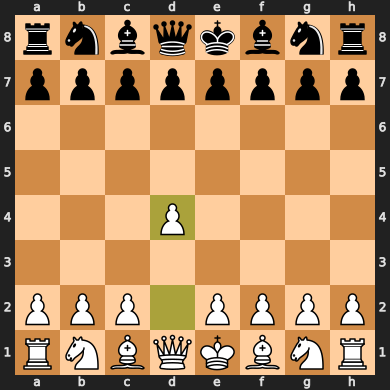

In [31]:
b = chess.Board()
c = chess.Move(
    chess.parse_square("d2"),
    chess.parse_square("d4")
)

b.push(c)
b


P
c4


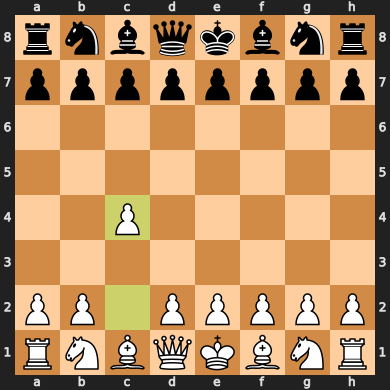

P
f6


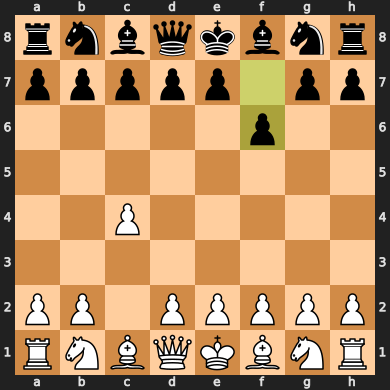

P
e4


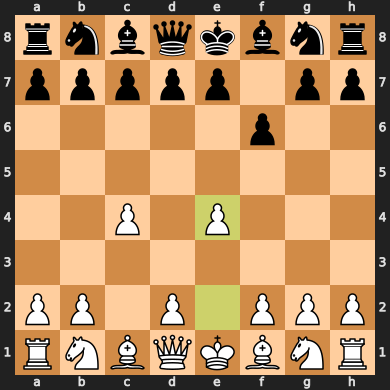

P
c5


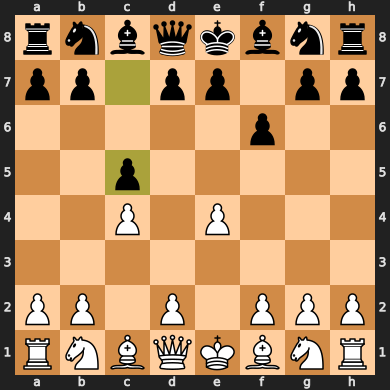

P
c3
P
e3
P
f4


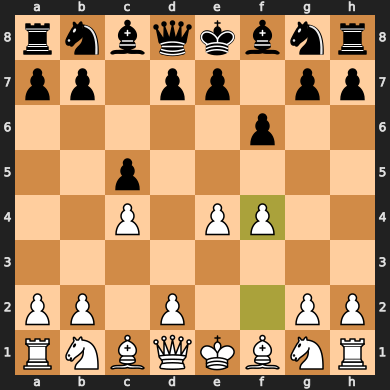

P
e6


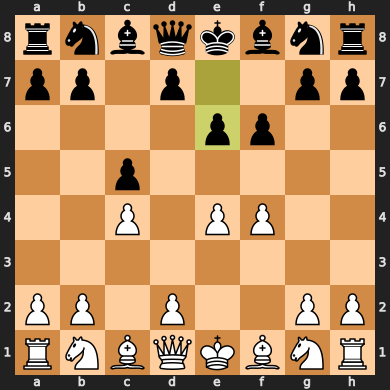

P
c8
P
d3


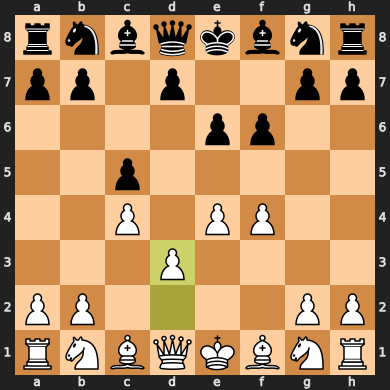

P
e6
P
d5


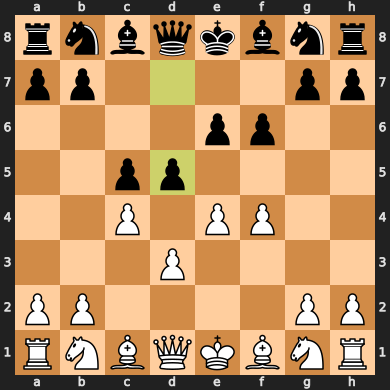

N
NO MOVE !! 
Nd2


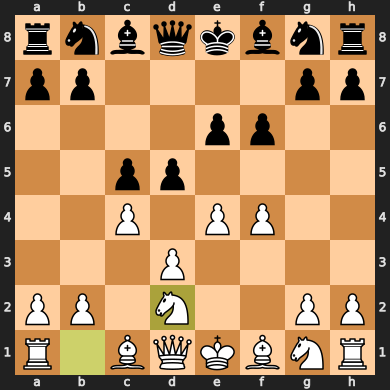

P
f5


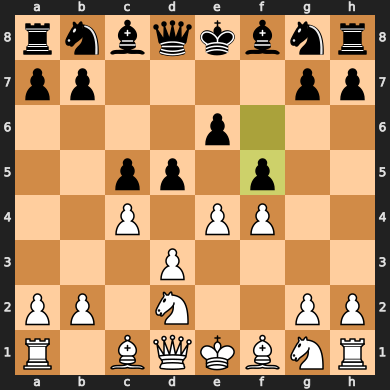

<LegalMoveGenerator at 0x7f85ee018eb0 (Ndf3, Nb3, Nb1, Nh3, Ngf3, Ne2, Be2, Kf2, Ke2, Qh5+, Qg4, Qa4+, Qf3, Qb3, Qe2, Qc2, Rb1, exf5, exd5, cxd5, e5, d4, h3, g3, b3, a3, h4, g4, b4, a4)>


In [20]:
from random import choices
from chess import IllegalMoveError    

model.eval()
model.cpu()

game_chess = chess.Board()

white_turn = True

for i in range(10):
    # Computer turn
    input_board = board_encoding(str(game_chess), white_turn)
    
    input_board = torch.tensor(input_board).type(torch.FloatTensor)
    input_board = input_board.unsqueeze(0)

    y_pred = model(input_board)

    pred_piece, pred_row, pred_col = torch.split(y_pred, [6, 8, 8], dim=1)


    
    while True:
        try:
            softmax = nn.Softmax(dim=0)

            move_row = choices(list(row_letters), softmax(pred_row[0]))
            move_col = choices(list(column_letters), softmax(pred_col[0]))

            move_piece = torch.argmax(pred_piece, dim=1).item()
            #pred_row   = torch.argmax(pred_row, dim=1).item()
            #pred_col   = torch.argmax(pred_col, dim=1).item()

            piece_selected = pieces[move_piece]

            print(piece_selected)

            if piece_selected == "P":
                # move = column_letters[pred_col] + row_letters[pred_row]
                move = move_col[0] + move_row[0]

            else:
                print("NO MOVE !! ")
                move = piece_selected + move_col[0] + move_row[0]

            print(move)

            game_chess.push_san(move)
            display(game_chess)
        except IllegalMoveError:
            continue
        break
    

    white_turn = not white_turn

print(game_chess.legal_moves)
    

# Run our model in FHE

## Compile our model to concreteML

Concrete ML implements model inference using Concrete as a backend. In order to execute in FHE, a numerical program written in Concrete needs to be compiled. 

The compilation process can be decomposed into three phases:

- Tracing the NumPy program and creating a Concrete op-graph
- Checking the op-graph for FHE compatability
- Producing machine code for the op-graph (determines cryptograpgic parameters)

For debugging purposes, it can be interesting to run ou model in **FHE simulation**. Indeed, by doing the first step, we can execute the op-graph on clear non-encrypted data allowing us to check quickly our model, as it is much faster than executing in FHE. Also, it can allow us to check the impact of the bit-widhts of our model layer using on FHE execution.

> More info: https://docs.zama.ai/concrete-ml/advanced-topics/compilation



## Optimization notes


Before compiling our model, we need to go over some points that impact it.


### P-Error - Setting the error

Concrete ML makes use of table lookups (TLUs) to represent any non-linear operation (e.g., a sigmoid). TLUs are implemented through the Programmable Bootstrapping (PBS) operation, which applies a non-linear operation in the cryptographic realm. The result of TLU operations is obtained with a specific error probability. Concrete ML offers the possibility to set this error probability, which influences the cryptographic parameters. The higher the success rate, the more restrictive the parameters become. This can affect both key generation and, more significantly, FHE execution time.

In Concrete ML, there are two different ways to define the error probability:

- Setting p_error, the error probability of an individual TLU 
- Setting global_p_error, the error probability of the full circuit 

> **__NOTE:__** If not defined, default parameters are used. It sets p_error = 2^-40 by default.

In Concrete ML, you cannot set both `p_error` and `global_p_error` simultaneously. They are somehow two concurrent parameters, in the sense they both have an impact on the choice of cryptographic parameters. The model complexity has an impact on the speed of the model. It can be interesting yo use an iterative approach to determine a good value for the `p_error` to have a good speed while preserving the good accuracy of the model. Beware that setting a too high value can significantly affect accuracy. [Concrete ML provides a tool](https://docs.zama.ai/concrete-ml/advanced-topics/advanced_features#searching-for-the-best-error-probability) to find a good `p_error` based on binary search algorithm.




> TODO :: See more about rounding_threshold_bits
> The rounding_threshold_bits parameter only works in FHE for TLU input bit-width less or equal to 8 bits. 


### Rounding operator



To speed-up neural networks, a rounding operator can be applied on the accumulators of linear and convolution layers to retain the most significant bits on which the activation and quantization is applied. The accumulator is represented using bits, and is the desired input bit-width of the TLU operation that computes the activation and quantization.

using rounding_threshold_bits argument can be set to a specific bit-width. It is important to choose an appropriate bit-width threshold to balance the trade-off between speed and accuracy. By reducing the bit-width of intermediate tensors, it is possible to speed-up computations while maintaining accuracy.

The rounding_threshold_bits parameter only works in FHE for TLU input bit-width less or equal to 8 bits. 


> Note: https://github.com/zama-ai/concrete-ml/blob/release/1.0.x/docs/advanced-topics/advanced_features.md#approximate-computations






-----------

The number of Tensor LookUp Units (TLUs) needed for your model. In Convolutional Neural Networks (CNNs), this number per layer equals channels x width x height. Your architecture has relatively low numbers in these, so there might not be a need for much optimization here.

-------




In [ ]:
from concrete.ml.torch.compile import compile_torch_model, compile_brevitas_qat_model

# Transform our model to cpu 
model = model.to("cpu")
model.eval()

train_loader = DataLoader(training_chess, batch_size=1, shuffle=True, num_workers=1)

data_calibration, _ = next(iter(train_loader))

# compile_torch_model

t = time.time()

fhe_model = compile_brevitas_qat_model(
    model, 
    data_calibration, 
    n_bits = N_BITS_QAT,
    # global_p_error=0.1,
    p_error=0.1,
    # verbose=True,
    # show_mlir=True,
) 

#, import_qat=True, n_bits=n_bits_qat)

# p_error=0.1)

print(f"Compilation time: {time.time()-t:.2f}s")


## Analyze the bit width

When compile your model to FHE, it could be interesting to see bit width used on our compile model. This can be seen using:

The maximum bitwidth used in your model, accessible via compiled_model.fhe_circuit.graph.maximum_integer_bit_width(). If this number is more than 8 bits, you're in the worse case scenario for the precision. 


In [ ]:
fhe_model.fhe_circuit.graph.maximum_integer_bit_width()

This can be analyzed more granuarly, from each layer

In [ ]:
fhe_model.bitwidth_and_range_report()

In our case, as you can see, we have a maximum of 11 bits. One possibility to lower the precision without damaging the accuray could be to implement our model using [Brevitas](https://docs.zama.ai/concrete-ml/developer-guide/inner-workings/external_libraries#brevitas), defining the weights and activation to be 4 bits.



### Test our model under FHE

Testing our model under FHE can be long and costly on a laptop. A possibility to test our approach is to enable a sumulate mode for FHE.

More info: https://docs.zama.ai/concrete-ml/deep-learning/fhe_assistant#simulation


In [ ]:


fhe_mode = "simulate"

if FHE_MODE == 1:
    fhe_mode = "execute"


game_chess = chess.Board()
white_turn = True

for i in range(4):
    # Computer turn
    input_board = board_encoding(str(game_chess), white_turn)

    input_board = torch.tensor(input_board).type(torch.FloatTensor)
    input_board = input_board.unsqueeze(0)

    y_pred = fhe_model.forward(data_calibration.detach().numpy(), fhe=fhe_mode)
    y_pred = y_pred[0]
    
    pred_row, pred_col = y_pred[0:8], y_pred[8:16]

    pred_row = np.argmax(pred_row).item()
    pred_col = np.argmax(pred_col).item()

    move = column_letters[pred_col] + row_letters[pred_row]
    print(move)
    
    game_chess.push_san(move)
    display(game_chess)

    white_turn = not white_turn
    


# Client / Server communication


We have generated our model in FHE. Now we are going to deploy it using a simple client/server architecture. The idea here is to see how we can deploy our model in FHE.

More ressources: https://github.com/zama-ai/concrete-ml/blob/release/1.0.x/docs/advanced_examples/ClientServer.ipynb

In [ ]:
!mkdir ./deploy
!mkdir ./deploy/server/
!mkdir ./deploy/client/
!mkdir ./deploy/keys/

In [ ]:
from concrete.ml.deployment import FHEModelClient, FHEModelDev, FHEModelServer


if not os.path.exists("./deploy/server/server.zip"):
    # Generate keys first, this may take some time (up to 30min)
    t = time.time()
    fhe_model.fhe_circuit.keygen()
    print(f"Keygen time: {time.time()-t:.2f}s")
    
    # Save it
    fhemodel_dev = FHEModelDev("./deploy/server/", fhe_model)
    fhemodel_dev.save()
    

In [ ]:
# Move the client
!mv ./deploy/server/client.zip ./deploy/client/

In [ ]:
# Now that the model has been trained we want to save it to send it to a server
fhemodel_dev = FHEModelDev("./deploy/server/")

- client.zip - contains cryptographic parameters to be sent to the client for them to create the keys (can easily be served via HTTP request). also contains the description of the pre-processing and post-processing that must be applied before encryption and after decryption.
- server.zip - contains everything required to do homomorphic prediction.


In [ ]:
!ls ./deploy/server/

In [ ]:
!ls ./deploy/client/

In [ ]:
fhemodel_client = FHEModelClient("./deploy/client/", key_dir="./deploy/keys/")

if not os.path.exists("./deploy/keys/"):
    
    print("Generated the keys...")
    
    t = time.time()
    fhemodel_client.generate_private_and_evaluation_keys()
    print(f"Keygen time: {time.time()-t:.2f}s")

In [ ]:
t = time.time()
serialized_evaluation_keys = fhemodel_client.get_serialized_evaluation_keys()
print(f"Serialized time: {time.time()-t:.2f}s")

In [ ]:
!ls ./deploy/keys/

In [ ]:
# Evaluation keys can be quite large files but only have to be shared once with the server.

# Check the size of the evaluation keys (in MB)
print(f"Evaluation keys size: {len(serialized_evaluation_keys) / (10**6):.2f} MB")

# Let's send this evaluation key to the server (this has to be done only once)
with open("./deploy/server/serialized_evaluation_keys.ekl", "wb") as f:
        f.write(serialized_evaluation_keys)

In [ ]:
# Client side

# Create a new chess board
game_chess = chess.Board()

# Encode it
input_board = board_encoding(str(game_chess), True)

input_board = torch.tensor(input_board).type(torch.FloatTensor)
input_board = input_board.unsqueeze(0)

encrypted_input = fhemodel_client.quantize_encrypt_serialize(input_board.numpy())

In [ ]:
# Server treatment

# Read the key of the dedicated client
with open("./deploy/server/serialized_evaluation_keys.ekl", "rb") as f:
    serialized_evaluation_keys = f.read()

# Predict the user input
time_begin = time.time()
encrypted_prediction = FHEModelServer("./deploy/server/").run(
    encrypted_input, serialized_evaluation_keys
)
time_end = time.time()

print(f"Prediction time: {time_end - time_begin:.2f}s")

In [ ]:
# Send back the encrypted input to the user
prediction = fhemodel_client.deserialize_decrypt_dequantize(encrypted_input)

In [ ]:
prediction

In [ ]:
# Link chess video
# https://www.youtube.com/watch?v=aOwvRvTPQrs